# Locust - Express Tutorial

According to [official website](https://docs.locust.io/en/stable/what-is-locust.html), 

*Locust is an easy-to-use, distributed, user load testing tool. It is intended for load-testing web sites (or other systems) and figuring out how many concurrent users a system can handle.*

- Allows you to write test scenarios in plain code using Python
- Distributed, Scalable and Support thousands of concurrent users even on a small machine
- Web UI helps you monitor your tests in realtime
- Mainly web-based but can test any type of system by simply customizing your own clients

## Installation & Setup
- install python, if not done already ([Official Download Link](https://www.python.org/downloads/))
    - can use [Homebrew](https://mxcl.github.com/homebrew/) for mac 
- install PyCharm - **OPTIONAL** (Python IDE - [Community Edition Download Link](https://www.jetbrains.com/pycharm/download/#section=windows))
- setup a virtual environment for your locust project
- pip install locust
- Since, every OS technically opens a file when establishing a HTTP connection, you may get an error for "[Increasing Maximum Number of Open Files Limit](https://docs.locust.io/en/stable/installation.html#increasing-maximum-number-of-open-files-limit)". To fix it, each OS will have different methods

## Basics

### Project Structure (personal preference)

Though it will be a personal preference but I like to organize my locust performance testing project (I use PyCharm) with following folders:

- PROJECT ROOT
    - **locustscripts**: can contain all locust test scripts
    - **common**: can contain helper modules used in the test scripts like authorization, authentication, __init__, etc.. which can be imported using import like *import common.module_name*
    - **data**: can contain data files like CSVs used but the test scripts
    - **config**: can contain config files for test environment setup
    - **logfiles**: can contain logfiles generated by running locust scripts
    - **requirements.txt**: External Python dependencies

### Basic Locust script & its components

In [ ]:
# for now just ignore the code and run it as is to verify if the environment is working or not
# details of these classes are explained below
from locust import User, HttpUser, task, between


class DeviOnWheelsWebUser(HttpUser):
    """Basic Http user class which inherits from locust HttpUser class"""
    
    wait_time = between(2, 5)
    host = "https://devilonwheels.com"

    @task
    def browse_homepage(self):
        self.client.get("/")

class DeviOnWheelsUtilityUser(User):
    """Basic user class which inherits from locust user class"""
    
    wait_time = between(2, 5)

    @task
    def perform_some_work(self):
        print("Automatically create posts on social media...")

### Running the script

To run this basic script, you can use the following command:

In [ ]:
locust -f <your_script_name_with_absolute_path>

After running the above command, the locust UI will be available at http://localhost:8089 which is the default port setting for locust.

On the landing page of Locust instance you will find below fields to start your tests

- **Users**: Total number of users to simulate the load for the test
- **Hatch Rate**: Number of users that will get linerarly added every second 
- **Host**: Base URL of the system which needs to be load tested


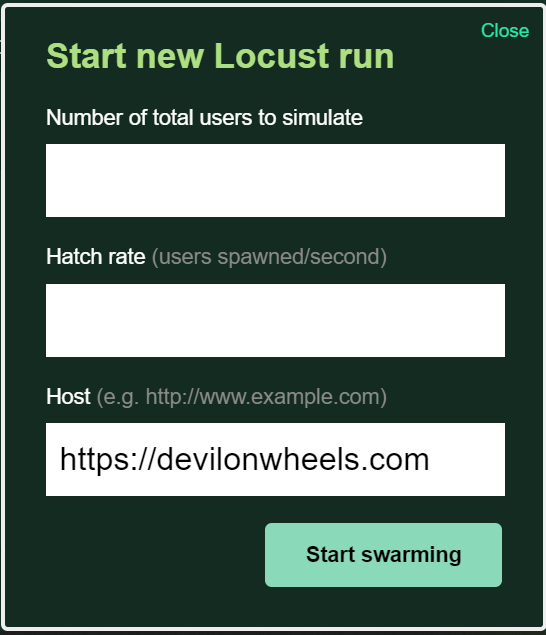



### Components of a basic Locust script

#### User or HttpUser Class

To create a basic locust script, we create a class that will simulate a user and inherit it from either User or HttpUser class of locust based on the use case. When we execute the script, each user in specified number of total users will create an instance of this User class and perform some actions defined in it.

Well, the HttpUser class also inherits from User class but then provides additional attributes and behaviours for supporting with HTTP protocol

#### @task decorator 

Each User class must have a method with a @task decorator that defines the task or operation which user will perform in the script

#### wait_time attribute

When a single simulated user run for a given amount of time (script runtime), it may perform many iterations. Within each iteration the user performs tasks defined in the user class. And the iteration continues till script is stopped or defined runtime expires. Now within these iterations of this single user, we need to specify some buffering which is defined by this attribute called called wait_time. Below three ways are available in Locust to define the wait time:

- **between(n1,n2):** User will wait randomly anywhere between n1 and n2 seconds interval
- **constant(n):** User will wait for exactly n seconds interval after completing previous iteration
- **constant_pacing(n):** User will wait for exactly (n - previous_task_duration) seconds after completing previous iteration and will immediately begins in case (n - previous_task_duration) <=0, that is, the wait time will be 0 in that case


#### host attribute (applicable to HttpUser Class)

Applicable only the HttpUser Class, this attributes defines the **base URL** of the host system that you want to load test. You can either provide this host attribute 

- in the code, 
- in command line options,
- configuration file, or 
- in the locust Web UI

So, somewhere host must be defined when working with HttpUser class.

### Important methods to know

We understand now that during one whole test run every user comes in iteration and perform tasks. However, there will certainly be things that we want user to perform only once like user login or logout, loading user data, connecting to database, disconnecting from database, performing clean up activities, etc..


#### on_start() and on_stop() 
- need to be named as is
- useful for user level one time activities like login, logout
- will be executed for each user

#### test_start() and test_stop()
- used for running some code at the start or stop of a complete load test
- they are defined at module level with help of event listeners
- in distributed mode, they are only called at Master node
- can be given any name as long as listeners are defined
- useful for test level one time activities like opening/closing DB connections or files
- users start/stop hatching after or before these events
- will only be execute once for the test

#### init()
- Called once at the beginning of each locust process 
- It will be called for master as well as each worker
- useful if we need to share some kind of state between all users when worker starts

In [ ]:
from locust import HttpUser, task, between, events
from locust.runners import MasterRunner

@events.init.add_listener
def on_locust_init(environment, **kwargs):
    """Called once at the beginning of each locust process 
    """
    if isinstance(environment.runner, MasterRunner):
        print("I'm on master node")
    else:
        print("I'm on a worker or standalone node")

@events.test_start.add_listener
def on_my_test_script_start(**kwargs):
    """Called only once when the load test starts running 
    """
    print("Starting a new load test, open a data file")

@events.test_stop.add_listener
def on_my_test_script_stop(**kwargs):
    """Called only once when the load test stops running 
    """
    print("Stopping a new load test, close the data file")

class DeviOnWheelsWebUser(HttpUser):
    """Describing start and stop methods"""
    
    wait_time = between(2, 5)
    host = "https://devilonwheels.com"
    
    def on_start(self):
        """Called only once when each user starts running or 
            starts executing TaskSet (described below)
        """
        self.client.get("/login")

    @task
    def browse_homepage(self):
        self.client.get("/")
        
    def on_stop(self):
        """Called only once when each user stops running or 
            stops executing TaskSet via interrupt() (described below)
        """
        self.client.get("/logout")

## Understanding Locust UI

The starting screen has already been discussed above. In this section let us look at various metrics provided in the Locust UI

- Stop the test using Stop button
- Edit the users participating in the test using Edit Users
- Reset the stats collected using Reset Stats button
- number of requests
- number of failed requests. Details can be found in Failure tab
- Min, Max, Average, Median(50 percentile), 90 percentile
- RPS(Requests Per Second) is available for individual requests as well as aggregated total for all requests. It indicates how many requests are reaching the server per second among the load of all our users
- Download Data can allow us to download all this data for our complete test in a CSV format

## Command line & Headless mode

We use the following command when we have to run Locust script

*locust -f your_script_name_with_absolute_path*

Once executed, this command let us run the load tests with the help of Locust Web UI.

However, if we want to run Locust based load tests without its UI, which is common scenario in the CI integration, we can use following command line options to **run Locust in Headless mode**.

* **--headless**: tells locust to run without UI 
* **-u or --users**: total number of users to swarm in load test
* **-r or --hatch-rate**: Hatch rate i.e. users added per second in the test
* **-t or --runtime**: total time limit for test execution after which locust will shutdown. It will stop all the running tasks immediately. Example --runtime 1h30m15s
* **--stop-timeout**: you can specify the stop timeout in seconds if you do want locust to wait for sometime before shutting down all the tasks once runtime is elapsed.
* **--logfile**: allows you to specify the path of log file where the output will be redirected
* **--log-level**: allows you to specify level of logging like DEBUG, INFO, CRITICAL (Default is INFO)
* **--csv**: allows you to specify the Folder path where you want stats of the tests to download. You can give -t5m additional paramater with --csv option so as to tell locust when to download the stats file in this folder.
    - If you provide -t option then for test to continue running use the --runtime option name for test execution time else test will stop because of -t
    - We can also programatically define when the interval when these CSVs will be written by locust using *locust.stats.CSV_STATS_INTERVAL_SEC* which is by default = 2 seconds
* **--only-summary**: after the run only summary results are displayed

## Multiple User Types (Eg: Mobile & Web)

When you need to run the same performance script for multiple type of environments of your application at the same time. Example, you want to run the same script for Mobile user as well as Web user of your application.

In [ ]:
from locust import User, HttpUser, task, between


class DeviOnWheelsWebUser(HttpUser):
    """Web user to simulate load of web based user"""
    
    # Weight attribute is decribed below
    weight = 1
    wait_time = between(2, 5)
    host = "https://devilonwheels.com"

    @task
    def browse_homepage(self):
        self.client.get("/")

class DeviOnWheelsMobileUser(HttpUser):
   """Mobile user to simulate load of amp/mobile based user"""
    
    # Weight attribute is decribed below
    weight = 3
    wait_time = between(2, 5)
    host = "https://amp.devilonwheels.com"

    @task
    def browse_homepage(self):
        self.client.get("/")

If you want to run one of these users only, then you can execute following command:

In [ ]:
locust -f <your_script_name_with_absolute_path> <user_class_name>
# Example
locust -f my_script.py MobileUser

### Weight Attribute for User classes

When a script having multiple user types execute, it divides the load evenly. Example, if you specify 10 total users to simulate for above script, the script will execute for 5 Web Users and 5 Mobile Users.

But, in real world the load on either web based app will be more or for generic blog type website like mine, mobile user load will be more as a lot of people access using it.

So, in order to divide the load of your script according to your use case, we can use **Weight attribute**.

Hence, my script above will always distribute the users in 1(Web):3(Mobile) ratio.

## Tasks & Tasksets

### Task Weights

As in real world scenarios, there will be many tasks defined under a user class. By default, the probability of user picking those defined tasks in its subsequent iterations is equal. However, in general, some parts of any application gets more load than others. 

So, to increase the probability or likelihood of tasks among each other in a particular user class or taskset, we can specify the task weight by passing it as parameter in **@task(task_weight)** decorator.

In [ ]:
from locust import User, HttpUser, task, between


class DeviOnWheelsWebUser(HttpUser):
   """Web user to simulate load of web based user"""
    
    wait_time = between(2, 5)
    host = "https://devilonwheels.com"

    @task(8)
    def browse_homepage(self):
        """Sets the probability of user picking this task in an iteration = 8"""
        self.client.get("/")
        
    @task(1)
    def create_calendar_event(self):
        """Sets the probability of user picking this task in an iteration = 8"""
        self.client.get("/travelcalendar")

### Task Attributes

In [ ]:
from locust import User, HttpUser, task, between


def browse_homepage(user_class):
   """defining the tasks at module level"""
    user_class.client.get("/")


def create_calendar_event(user_class):
    """defining the tasks at module level"""
    user_class.client.get("/travelcalendar")


class DeviOnWheelsWebUser(HttpUser):
    """Web user to simulate load of web based user"""

    wait_time = between(2, 5)
    host = "https://devilonwheels.com"

    # use tasks attribute to define tasks as a list of defined functions
    # in this case probability will be same for these tasks getting picked
    tasks = [browse_homepage, create_calendar_event]
    
    # use dictionary to define tasks for providing weights to the tasks
    # in this case probability will be based upon these weights
    tasks = {browse_homepage:8, create_calendar_event:1}

### Tasksets

Tasksets are used to organize or categorize the tasks of the application under test at python module level. We can categorize the tasks of application functions into various taskset classes and then enlist them using task attribute in the main User class.

Taskset class can be defined within the User class, that is inline to that class

In [ ]:
from locust import TaskSet, HttpUser, task, between


class TravelCalendar(TaskSet):

    """Task set class for testing functionality related to travel calendar"""

    @task(8)
    def browse_homepage(self):
        """Sets the probability of user picking this task in an iteration = 8"""

        self.client.get("/")
        print("Browsing homepage")

    @task(1)
    def create_calendar_event(self):
        """Sets the probability of user picking this task in an iteration = 1"""

        # self.client.get("/travelcalendar")
        print("Creating calendar entry")


class DeviOnWheelsWebUser(HttpUser):
    """Web user to simulate load of web based user"""

    wait_time = between(2, 5)
    host = "https://devilonwheels.com"

    # use tasks attribute to define tasks as a list of defined functions or Taskset classes
    tasks = [TravelCalendar]


### Sequential Tasksets

By **inheriting from SequentialTaskset class** instead of Taskset class you can enforce that when user enters a test execution iteration, it picks the defined tasks in the class always in an order. Each time user enters a iteration of the loop, it will always pick the task which is defined next to the task that user completed in the last iteration.


### Nested Tasksets

In order to keep different tasks further organized within a taskset class, you define one or more Taskset classes within one Taskset class. These are called nested tasksets.

However, you need a way to interrupt the user so that it can pick other tasksets defined because once a user enter one of the tasksets, it will enter an infinite loop and keep executing tasks defined in one taskset only.

This problem is solved by **self.interrupt(reschedule=True)** method. Passing the argument value as True will let Parent taskset to reschedule some other taskset nested under it.

In [ ]:
from locust import TaskSet, HttpUser, task, between


class TravelCalendar(TaskSet):
    """Example of nested Taskset class for testing functionality related to travel calendar"""

    @task(2)
    class BrowseCalendar(TaskSet):

        @task(2)
        def filters_setup(self):
            self.client.get("/")
            print("Setting up filters on calendar")

        @task(5)
        def check_existing_events(self):
            print("Browsing existing entries in the calendar")

        @task(1)
        def stop(self):
            self.interrupt(True)
            print("Stopping to browse calendar")

    @task(1)
    class UpdateCalendar(TaskSet):

        @task(4)
        def create_event(self):
            print("Creating calendar entry as user could not find existing")

        @task(2)
        def edit_event(self):
            print("Editing my own calendar entry")

        @task(1)
        def stop(self):
            self.interrupt(True)
            print("Stopping to edit calendar")


class DeviOnWheelsWebUser(HttpUser):
    """Web user to simulate load of web based user"""

    wait_time = between(2, 3)
    host = "https://devilonwheels.com"

    # use tasks attribute to define tasks as a list of defined functions or Taskset classes
    tasks = [TravelCalendar]


## Working with HTTP

## Working with REST APIs

## Logging

## Setting up testing environment

- Note from [official documentation](https://docs.locust.io/en/stable/installation.html#installing-locust-on-windows) *Running Locust on Windows should work fine for developing and testing your load testing scripts. However, when running large scale tests, it’s recommended that you do that on Linux machines, since gevent’s performance under Windows is poor.*

## Running tests in Distributed Mode

- One Master, Multiple Workers (locust instance). Master coordinate the tests, collect stats, metrics, messages, errors, etc.. and workers does the execution
- One worker will take one CPU core. # of locust instances which can run on one machine is number of CPU cores it has
- Run the master first, then run workers by specifying master IP and port combination (default 5557)
- Do not use the pop method to extract the users rather use random module to randomize the users in these workers. it will reduce probablity of picking same users which will be certain in pop method.
- Advance methods exist where workers can communicate with each other as well to give exclusivity to users management.
- Supports headless mode

## Running tests with Docker & Docker Compose

## Advanced Concepts